<a href="https://colab.research.google.com/github/DevashishX/AbstractClustering/blob/master/templates/KmeansGlovePmeans5_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Requirements

This file has been modified for colab training, all outputs are stored in *ColabOutput* folder in your google drive, there is also a one copy in the normal training folders as well.
*Make sure you have ColabOutput folder in your google drive*

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/DevashishX/AbstractClustering.git; 
!cp -r AbstractClustering/* ./.

Cloning into 'AbstractClustering'...
remote: Enumerating objects: 741, done.
remote: Total 741 (delta 0), reused 0 (delta 0), pack-reused 741
Receiving objects: 100% (741/741), 765.35 MiB | 30.68 MiB/s, done.
Resolving deltas: 100% (374/374), done.
Checking out files: 100% (439/439), done.


In [0]:
import subprocess
print((subprocess.check_output("lscpu", shell=True).strip()).decode())

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

# ***Set parameters***

In [0]:
__algo__ = "KMEANS"               #Name of the Clustering algorithm
__emb__ = "glove"                 #Name of the Word Embeddings used (glove, w2v, ftt), MUST set directory below
__sentemb__ = "pmeans5"           #Name of Sentence Embedding algorithm used
recnum = 30000                     #Number of records to be read from files
k = 350                           #Number of Clusters
usesqrt = False                   #Set value of k to sqrt of recnum, overrides k
randomsample = True              #Random Sampling to be True/False for records which are read
embedDir = "./MegaSentEmbs/"     #Directory where embeddings are saved for that selected embedding
modelDir = "./models/"           #Directory where models are saved
megadfDir = "./MegaDfs/"         #Directory Where Megadf is to be saved
plotDir = "./plots/"             #Directory where plots are saved
metadataDir = "./modelMetaData/" #Directory where performance and distribution params are to be stored
dumpDir = "./dump/"              #Directory where test outcomes are saved

# Actual Code

### imports and time

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import cluster, datasets
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import os, subprocess, sys
import datetime, time
import pickle

### File Settings

In [0]:
oldlist = os.listdir(embedDir)
filelist = sorted([embedDir+f for f in oldlist if f[-3:]=="pkl"])
filenum = len(filelist)
smalllist = filelist[:filenum]
print("Length of Smalllist: ", len(smalllist))

Length of Smalllist:  116


### Number of Records
It is Recommended to Set this at the top parameters

In [0]:
recnum = recnum

### Read all the pandas dataframes

In [0]:
%%time
megadf = pd.DataFrame()

if randomsample == True:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
    megadf = megadf.sample(recnum, random_state=42)
else:
    print("randomsample: ", randomsample)
    for f in smalllist:
        tempdf = pd.read_pickle(f)
        megadf = megadf.append(tempdf, ignore_index = True)
        if megadf.shape[0] >= recnum:
            megadf = megadf[:recnum]
            break

print("megadf.shape: ", megadf.shape)

randomsample:  True
megadf.shape:  (30000, 4)
CPU times: user 8.24 s, sys: 871 ms, total: 9.11 s
Wall time: 9.12 s


In [0]:
predata = megadf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(30000, 250)


### Number of Clusters
It is Recommended to Set this at the top parameters

In [0]:
if usesqrt == True:
    print("usesqrt: ", usesqrt)
    sqrt_k = int(np.sqrt(data.shape[0]))
    k = int(sqrt_k)
else:
    print("usesqrt: ", usesqrt)
    k = k
print("k: ", k)

usesqrt:  False
k:  350


## Clustering
Please modify the functions here to change algorithm

In [0]:
%%time
print("Starting Clustering Process")
start_time = time.time()
model = cluster.KMeans(n_clusters=k, n_init = 20, max_iter=1000, verbose=1, n_jobs=-1)
model.fit(data)
end_time = time.time()
timetrain = round(end_time-start_time, 2)
print("done! {}".format(timetrain))
print("k_means.fit(data) Done!")

Starting Clustering Process


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done! 862.78
k_means.fit(data) Done!
CPU times: user 231 ms, sys: 238 ms, total: 469 ms
Wall time: 14min 22s


### Saving the output data into vars

In [0]:
centroids = model.cluster_centers_
labels = model.labels_
megadf["clusterlabel"]=labels
centroidDF = pd.DataFrame(centroids)


In [0]:
display(megadf["clusterlabel"])
display(centroidDF)

267625    114
132693    254
42457     226
11052     166
13984      15
         ... 
18574      25
44937     207
127685     71
159718    113
142878     65
Name: clusterlabel, Length: 30000, dtype: int32

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0.177503,0.220895,0.313306,0.120603,0.055730,0.193860,0.366736,-0.399598,0.094650,0.266527,0.351354,-0.057419,0.042105,0.135944,-0.241383,0.206174,-0.076298,0.073238,-0.297151,-0.369672,0.040202,-0.312779,0.205128,-0.072471,0.017197,-0.380409,-0.159185,0.122349,0.216597,0.114122,1.824937,-0.159476,-0.020190,-0.348601,0.040671,-0.091682,0.166882,0.112042,0.014752,0.147722,...,0.818121,0.698651,0.755658,0.800157,0.861988,0.684045,0.711001,0.767878,0.920260,0.880717,0.734427,0.801547,0.837959,0.711872,0.667597,1.124374,0.776239,0.751776,0.775775,0.759959,2.610431,0.784974,0.726243,1.010085,0.667392,0.711143,0.697058,0.785221,0.733750,0.741890,0.877838,0.597348,0.706777,0.769823,0.788758,0.722523,0.977050,0.825815,0.732845,0.715460
1,0.203889,0.085882,-0.143129,-0.089254,0.271657,0.299424,0.090765,-0.209305,-0.014825,0.169567,0.102178,0.086133,-0.097858,-0.046659,0.130874,0.121880,0.069545,-0.156076,0.106670,-0.330532,0.006922,0.001004,0.028436,0.021568,0.247550,-1.010542,-0.389908,-0.081428,0.181999,0.097992,2.303821,-0.095013,-0.257268,-0.656409,-0.023134,-0.125514,0.045418,0.094163,-0.224522,-0.069186,...,0.654698,0.619419,0.689259,0.610484,0.725296,0.601902,0.623074,0.645287,0.723599,0.708515,0.654867,0.669745,0.632466,0.646371,0.748979,1.485762,0.861592,0.635620,0.741723,0.710603,2.825934,0.769447,0.795159,1.052805,0.642680,0.647064,0.650680,0.676918,0.691314,0.636624,0.683939,0.623881,0.648501,0.852222,0.744162,0.587309,0.822454,0.969754,0.639874,0.680940
2,0.019372,0.119154,-0.092583,-0.019034,0.260721,0.098190,-0.532485,-0.253882,0.100802,-0.153153,-0.166489,-0.033742,-0.033243,-0.127774,0.102369,0.082264,-0.075712,-0.011384,-0.241977,-0.235239,0.469668,-0.120682,0.062060,0.051192,-0.176462,-0.780298,-0.207340,0.086547,0.166118,-0.083185,1.905280,-0.233328,-0.011475,0.026110,0.115207,-0.026220,0.043470,0.232002,0.081210,-0.174788,...,0.712482,0.657630,0.904237,0.777346,0.832110,0.499724,0.842675,0.653396,0.926539,0.759778,1.051968,0.726058,0.984620,0.671260,0.656544,1.274789,0.823220,0.823342,0.773795,0.695993,2.617866,0.709995,0.727284,1.014832,0.730585,0.704739,0.720745,0.745238,0.757558,0.639784,0.754672,0.561272,0.635402,0.823320,0.818195,0.708557,0.629471,0.855730,0.547864,0.688711
3,0.238215,0.179073,0.125665,-0.060096,0.083500,0.199667,-0.059631,-0.239650,0.158899,-0.021216,0.168381,-0.084588,-0.041847,0.062883,-0.052537,0.148186,0.016011,0.028246,-0.281547,-0.424631,0.029704,-0.149994,0.059428,-0.079246,0.093003,-0.760848,-0.165925,0.151107,0.216858,0.105443,2.301393,-0.053335,-0.036483,-0.318618,0.069306,0.041241,0.117412,0.151627,-0.040546,-0.025712,...,0.692613,0.731509,0.771844,0.791821,0.827422,0.658934,0.707986,0.769046,0.938625,0.924486,0.782627,0.743466,0.780955,0.687887,0.683290,1.293915,0.784318,0.810893,0.790681,0.749952,2.844595,0.786935,0.748675,0.984668,0.672558,0.682471,0.700327,0.712004,0.757146,0.691751,0.756722,0.634948,0.673373,0.738500,0.833289,0.691338,0.837132,0.891235,0.663493,0.711250
4,0.053860,0.265055,-0.054366,0.210886,-0.057046,-0.083283,-0.289663,-0.649952,0.147748,-0.148379,0.133967,0.313592,0.237271,0.001693,0.224304,-0.010196,-0.325805,-0.184947,-0.029272,0.037633,0.223528,-0.092551,0.090281,0.208271,0.003036,-0.470234,-0.422120,-0.191288,-0.187624,-0.117326,1.691306,-0.514468,-0.162733,-0.269018,-0.348738,0.033255,0.168012,-0.236740,0.023813,-0.089591,...,0.637937,0.715592,0.748261,0.623000,0.858553,0.433176,0.694533,0.791227,0.894163,0.688734,0.815303,0.572240,0.692016,0.746673,0.525048,1.152851,1.023850,0.758639,0.675880,0.628917,2.475141,0.978735,0.813457,0.930946,0.955473,0.600913,0.725668,0.738013,0.695996,0.520252,1.546082,0.576199,0.735210,0.814222,0.781824,0.629062,0.868178,0.788841,0.502459,0.554978
.

## Plotting

Text(0.5, 1.0, 'KMEANS with k=350 records=30000 features=250 using glove')

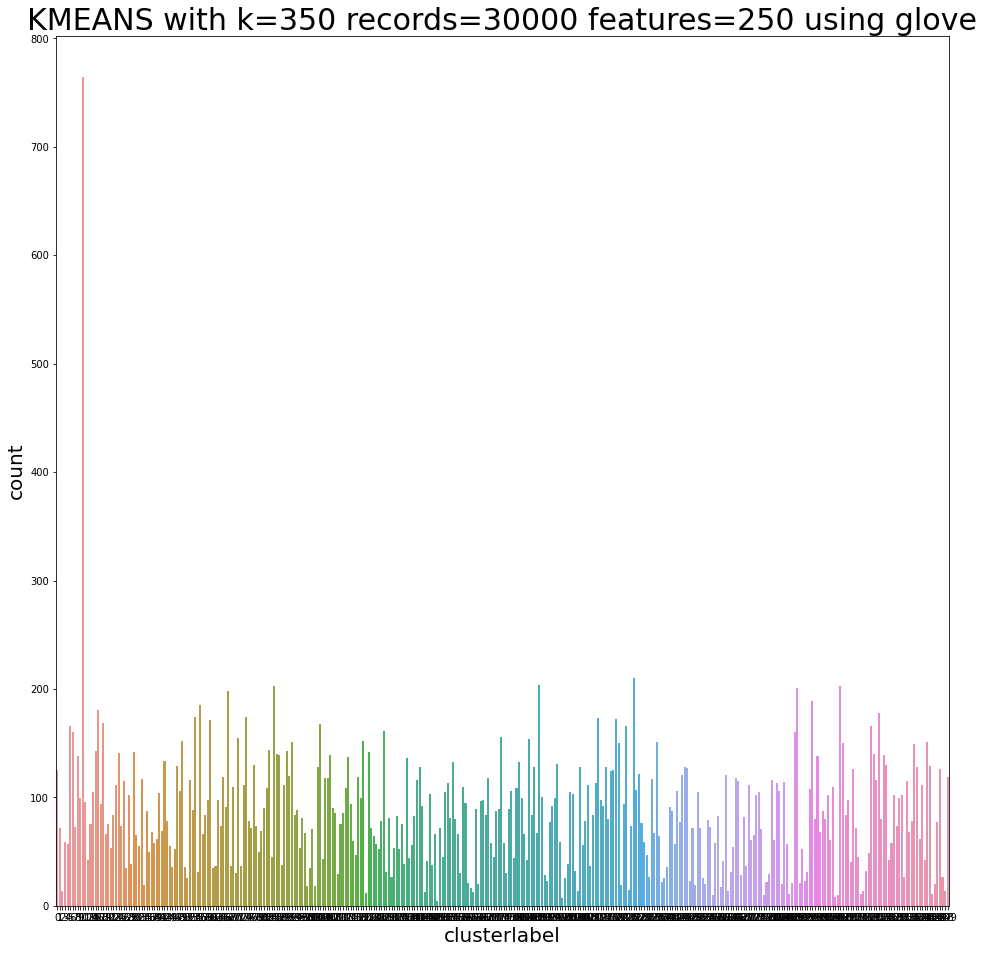

In [0]:
plt.figure(figsize=(16,16))
titlestring = "{} with k={} records={} features={} using {}".format(__algo__, k, data.shape[0], data.shape[1], __emb__)
snsplot = sns.countplot("clusterlabel", data=megadf)
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 30}
    )

### *Name given to saved files*

In [0]:
features = data.shape[1]
records = data.shape[0]
name = "{}_{}_{}_K{}_R{}_F{}".format(__algo__, __emb__, __sentemb__, k, records, features)
name

'KMEANS_glove_pmeans5_K350_R30000_F250'

### Saving Data

Save model

In [0]:
modelname = "{}_model.pkl".format(name)
pickle.dump(model, open(modelDir + modelname, 'wb'))
os.environ["SAVE_DF"] = modelDir + modelname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Plot

In [0]:
snspltname = "{}_plt.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)
os.environ["SAVE_DF"] = plotDir + snspltname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Megadf

In [0]:
clusterdfname = "{}_clustered_megadf.pkl".format(name)
megadf.to_pickle(megadfDir + clusterdfname)
os.environ["SAVE_DF"] = megadfDir + clusterdfname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

Save Centroids

In [0]:
centroidDF = pd.DataFrame(centroids)
centroidDFname = "{}_centroids.pkl".format(name)
centroidDF.to_pickle(megadfDir + centroidDFname)
os.environ["SAVE_DF"] = megadfDir + centroidDFname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.
print(centroidDF.shape)

(350, 250)


#### Open dataframe to test

In [0]:
sub = megadf.loc[:, ["id", "title", "abstract", "clusterlabel"]]
sub.tail()

,id,title,abstract,clusterlabel
18574,9013351,Trace (Layered Neck-piece and Feather Wrap),"[exhibition, two, large, printed, feather, bod...",25
44937,333129,"Equivalence of conservative, free, linear prog...","[program, schema, defines, class, program, ide...",207
127685,371081,The impact of structural adjustment programmes...,"[requirement, doctor, business, administration...",71
159718,7379292,"Neville Street, Water Lane, Great Wilson Street","[16th, february, neville, street, foreground, ...",113
142878,1537402,Paperless examination boards promote wider and...,"[series, development, since, inception, sits, ...",65


In [0]:
megadf.columns

Index(['id', 'title', 'abstract', 'embedding', 'clusterlabel'], dtype='object')

# Performance Testing and Distribution


In [0]:
metadata = pd.DataFrame(columns=["Name", "Algo", "WordEmb", "SentEmb", "K", "R", "F", "SS", "CSavg", "CSmin", "CSmax", "T2Pavg", "T2LM", "T2LMP", "MEM"])

In [0]:
metadict = {
    "Name":None,                     #Name of the save file prefix
    "Algo":None,                     #Name of the Clustering algorithm
    "WordEmb":None,                  #Name of the Word Embeddings used (glove, w2v, ftt)
    "SentEmb":None,                  #Name of Sentence Embedding algorithm used 
    "K":None, "R":None, "F":None,    #Number of clusters, records and fetures
    "T2T":None,                      #Time required to train model
    "SS":None,                       #Silhoutte Score
    "DBS":None,                      #Davis Bouldin Score
    "CSavg":None,                    #Average Cluster Size
    "CSmin":None,                    #Minimum Cluster Size
    "CSmax":None,                    #Maximum Cluster Size
    "T2Pavg":None,                   #Average Time To Predict cluster of one record
    "T2LM":None,                     #Average Time to Load Model
    "T2LMP":None,                    #Amortized time to Predict after loading the model
    "MEM":None                      #Memory used by the Model
    }
metadict

{'Algo': None,
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': None,
 'K': None,
 'MEM': None,
 'Name': None,
 'R': None,
 'SS': None,
 'SentEmb': None,
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': None}

In [0]:
metadict["Name"]=name
metadict["Algo"]=__algo__
metadict["WordEmb"]=__emb__
metadict["SentEmb"]=__sentemb__
metadict["K"]=k
metadict["R"]=recnum
metadict["F"]=features
metadict

{'Algo': 'KMEANS',
 'CSavg': None,
 'CSmax': None,
 'CSmin': None,
 'DBS': None,
 'F': 250,
 'K': 350,
 'MEM': None,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': None,
 'SentEmb': 'pmeans5',
 'T2LM': None,
 'T2LMP': None,
 'T2Pavg': None,
 'T2T': None,
 'WordEmb': 'glove'}

#### Time to train

In [0]:
metadict["T2T"]=timetrain

#### Scores

In [0]:
ss = silhouette_score(data, labels, metric = 'euclidean')
dbs = davies_bouldin_score(data, labels)
metadict["SS"]=ss
metadict["DBS"]=dbs

#### Cluster Size

In [0]:
clusterdata = megadf.groupby("clusterlabel", as_index=True).size().reset_index(name="count")
clusterdata.head()

,clusterlabel,count
0,0,125
1,1,72
2,2,14
3,3,59
4,4,57


In [0]:
clusterdfname = "{}_clustered_counts.pkl".format(name)
clusterdata.to_pickle(megadfDir + clusterdfname)
os.environ["SAVE_DF"] = megadfDir + clusterdfname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

In [0]:
countdata = clusterdata.groupby("count").size().reset_index(name="clusters")
display(countdata.head(3))
display(countdata.tail(3))

,count,clusters
0,4,1
1,7,1
2,8,1


,count,clusters
145,204,1
146,210,1
147,764,1


In [0]:
metadict["CSmax"] = max(clusterdata["count"])
metadict["CSmin"] = min(clusterdata["count"])
metadict["CSavg"] = np.mean(clusterdata["count"])

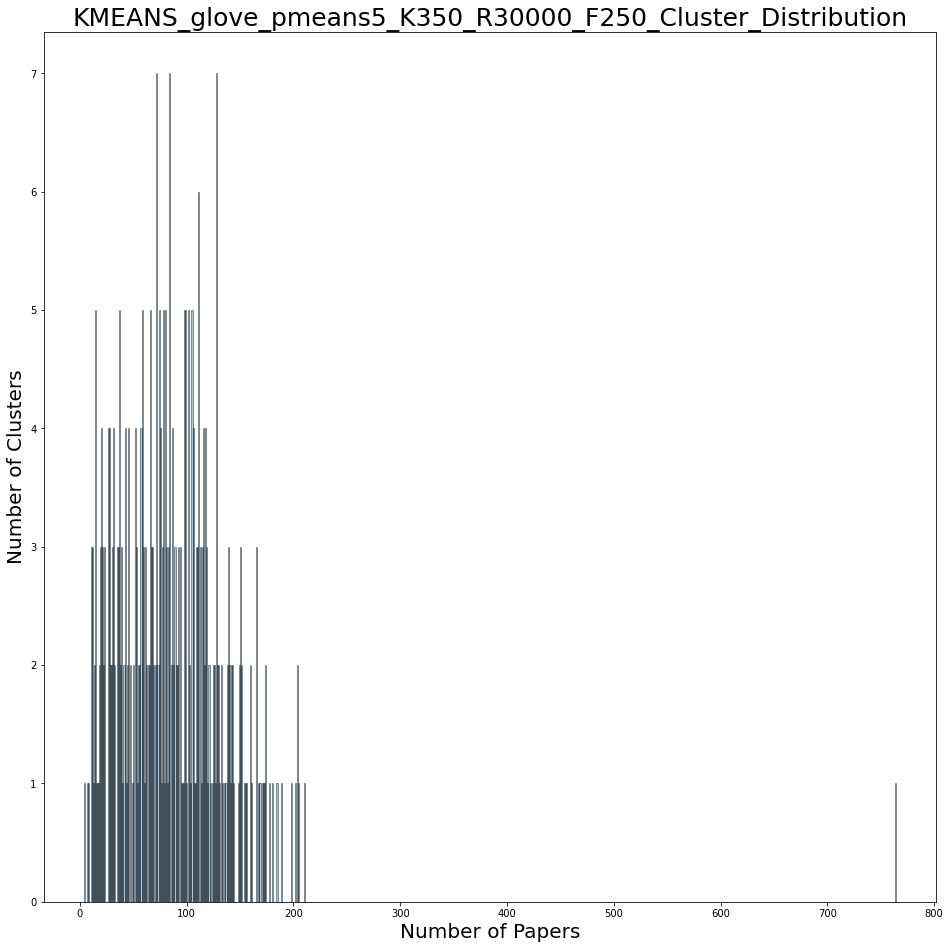

In [0]:
%matplotlib inline
plt.figure(figsize=(16,16))

sns.axes_style("whitegrid", {"axes.grid":True, 
                            'axes.spines.left': False,
                             'axes.spines.bottom': False,
                             'axes.spines.right': False,
                             'axes.spines.top': False})


titlestring = "{}_Cluster_Distribution".format(name)
snsplot = sns.distplot(clusterdata["count"], 
                       kde=False, 
                       bins=max(clusterdata["count"]),
                      hist_kws={'edgecolor':'black'},)
snsplot.set(xlabel="Number of Papers", ylabel="Number of Clusters")
snsplot.xaxis.label.set_size(20)
snsplot.yaxis.label.set_size(20)
plt.title(
        titlestring,
        fontdict = {'fontsize' : 25}
    )
plt.show()



In [0]:
snspltname = "{}_Cluster_Distribution.png".format(name)
snsplot.figure.savefig(plotDir + snspltname)
os.environ["SAVE_DF"] = plotDir + snspltname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

#### Prediction Time Performance

In [0]:
testdf = pd.DataFrame()
if recnum < 2000:
    samplenum = int(recnum / 10)
else:
    samplenum = 2000

for f in smalllist:
    tempdf = pd.read_pickle(f)
    testdf = megadf.append(tempdf, ignore_index = True, sort = False)
testdf = testdf.sample(samplenum, random_state=int(time.time()%100000))
predata = testdf["embedding"]
data = np.matrix(predata.to_list())
print(data.shape)

(2000, 250)


In [0]:
print("Starting Predicting Performance")
testmodel = model
start_time = time.time()
for d in data:
    lb = testmodel.predict(d)
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/data.shape[0]
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2Pavg"]=avgtime

Starting Predicting Performance
Avgtime: 0.0008862920999526977 Totaltime: 1.7725841999053955


In [0]:
print("Starting Loading Performance")
loadruns = 50
start_time = time.time()
for i in range(loadruns):
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
end_time = time.time()
timetest = end_time-start_time
avgtime = timetest/loadruns
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LM"] = avgtime
avgtime

Starting Loading Performance
Avgtime: 0.0005409288406372071 Totaltime: 0.02704644203186035


0.0005409288406372071

In [0]:
print("Starting Amortized Performance")
loadruns = 5
avglist = []

for i in range(loadruns):
    start_time = time.time()
    testmodel = pickle.load(open(modelDir + modelname, 'rb'))
    for d in data:
        lb = testmodel.predict(d)
    end_time = time.time()
    timetest = (end_time-start_time)/data.shape[0]
    avglist.append(timetest)

timetest = np.sum(avglist)
avgtime = np.mean(avglist)
print("Avgtime: {} Totaltime: {}".format(avgtime, timetest))
metadict["T2LMP"] = avgtime
avgtime

Starting Amortized Performance
Avgtime: 0.0008832240819931029 Totaltime: 0.004416120409965515


0.0008832240819931029

In [0]:
modelsize = sys.getsizeof(pickle.dumps(model))
print("modelsize:", modelsize, "bytes")
metadict["MEM"]=modelsize

modelsize: 820749 bytes


In [0]:
metadict

{'Algo': 'KMEANS',
 'CSavg': 85.71428571428571,
 'CSmax': 764,
 'CSmin': 4,
 'DBS': 3.5175272383194045,
 'F': 250,
 'K': 350,
 'MEM': 820749,
 'Name': 'KMEANS_glove_pmeans5_K350_R30000_F250',
 'R': 30000,
 'SS': 0.06316511641150116,
 'SentEmb': 'pmeans5',
 'T2LM': 0.0005409288406372071,
 'T2LMP': 0.0008832240819931029,
 'T2Pavg': 0.0008862920999526977,
 'T2T': 862.78,
 'WordEmb': 'glove'}

In [0]:
metadata = metadata.append(metadict, ignore_index=True)
metadata

,Name,Algo,WordEmb,SentEmb,K,R,F,SS,CSavg,CSmin,CSmax,T2Pavg,T2LM,T2LMP,MEM,DBS,T2T
0,KMEANS_glove_pmeans5_K350_R30000_F250,KMEANS,glove,pmeans5,350,30000,250,0.063165,85.714286,4,764,0.000886,0.000541,0.000883,820749,3.517527,862.78


In [0]:
metadataname = "{}_metadata.pkl".format(name)
metadata.to_pickle(metadataDir + metadataname)
os.environ["SAVE_DF"] = metadataDir + metadataname
!cp $SAVE_DF ./drive/My\ Drive/ColabOutput/.

In [0]:
print("All Done!\nCheck ColabOutput!")

All Done!
Check ColabOutput!
